<center>
    <h1>Assignment 2 - Question Answering with Transformers on CoQA</h1>
    <h2>Natural Language Processing</h2>
    <h3>Antonio Politano, Enrico Pittini, Riccardo Spolaor and Samuele Bortolato</h3>
    <h4>antonio.politano2@studio.unibo.it, enrico.pittini@studio.unibo.it, riccardo.spolaor@studio.unibo.it, samuele.bortolato@studio.unibo.it</h4>
</center>



---



Assignment description: see `Assignment.ipynb`.

In this notebook the QA task is addressed.

For more detailed informations about the used functions, look into the corresponding docstrings inside the python files, inside the `models` and `utils` folder.

In [3]:
import json
import numpy as np
import pandas as pd
import torch

In [4]:
# Settings for autoreloading

%load_ext autoreload
%autoreload 2

In [5]:
# Settings for reproducibility
from utils.seeder import set_random_seed

set_random_seed(42)

# [Task 1] Remove unaswerable QA pairs

## 1.1 Dataset download

The dataset is downloaded and saved in the `coqua` folder using the snippet of code provided in `Assignment.ipynb`.

In [6]:
import os
import urllib.request
from tqdm import tqdm

class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)
        
def download_url(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)

def download_data(data_path, url_path, suffix):    
    if not os.path.exists(data_path):
        os.makedirs(data_path)
        
    data_path = os.path.join(data_path, f'{suffix}.json')

    if not os.path.exists(data_path):
        print(f"Downloading CoQA {suffix} data split... (it may take a while)")
        download_url(url=url_path, output_path=data_path)
        print("Download completed!")

In [7]:
# Train data
train_url = "https://nlp.stanford.edu/data/coqa/coqa-train-v1.0.json"
download_data(data_path='coqa', url_path=train_url, suffix='train')

# Test data
test_url = "https://nlp.stanford.edu/data/coqa/coqa-dev-v1.0.json"
download_data(data_path='coqa', url_path=test_url, suffix='test')  # <-- Why test? See next slides for an answer!

## 1.2 Dataframe Creation

The train and test dataframes (`train_df` and `test_df`) are built. Each row contains information about a specific question and the corresponding answer along with their chronological collocation (`turn_id`) in the conversation. Furthermore informations about the passage containing the context and the history of previous questions and answers of the relative conversation is contained.

In [8]:
from utils.dataframe_builder import get_dataframe

train_df = get_dataframe(os.path.join('coqa', 'train.json'))
test_df = get_dataframe(os.path.join('coqa', 'test.json'))


## 1.3 Data Inspection

The heads of the train and test dataframes are shown below along with their shapes.

In [9]:
print(f'Train dataframe shape: {train_df.shape}')
train_df.head()

Train dataframe shape: (108647, 15)


,source,id,filename,story,name,question_input_text,question_turn_id,question_bad_turn,answer_span_start,answer_span_end,answer_span_text,answer_input_text,answer_turn_id,answer_bad_turn,history
0,wikipedia,3zotghdk5ibi9cex97fepx7jetpso7,Vatican_Library.txt,"The Vatican Apostolic Library (), more commonl...",Vatican_Library.txt,When was the Vat formally opened?,1,NaN,151,179,Formally established in 1475,It was formally established in 1475,1,NaN,[]
1,wikipedia,3zotghdk5ibi9cex97fepx7jetpso7,Vatican_Library.txt,"The Vatican Apostolic Library (), more commonl...",Vatican_Library.txt,what is the library for?,2,NaN,454,494,he Vatican Library is a research library,research,2,NaN,"[When was the Vat formally opened?, It was for..."
2,wikipedia,3zotghdk5ibi9cex97fepx7jetpso7,Vatican_Library.txt,"The Vatican Apostolic Library (), more commonl...",Vatican_Library.txt,for what subjects?,3,NaN,457,511,Vatican Library is a research library for hist...,"history, and law",3,NaN,"[When was the Vat formally opened?, It was for..."
3,wikipedia,3zotghdk5ibi9cex97fepx7jetpso7,Vatican_Library.txt,"The Vatican Apostolic Library (), more commonl...",Vatican_Library.txt,and?,4,NaN,457,545,Vatican Library is a research library for hist...,"philosophy, science and theology",4,NaN,"[When was the Vat formally opened?, It was for..."
4,wikipedia,3zotghdk5ibi9cex97fepx7jetpso7,Vatican_Library.txt,"The Vatican Apostolic Library (), more commonl...",Vatican_Library.txt,what was started in 2014?,5,NaN,769,879,"March 2014, the Vatican Library began an initi...",a project,5,NaN,"[When was the Vat formally opened?, It was for..."


In [10]:
print(f'Test dataframe shape: {test_df.shape}')
test_df.head()

Test dataframe shape: (7983, 14)


,source,id,filename,story,additional_answers,name,question_input_text,question_turn_id,answer_span_start,answer_span_end,answer_span_text,answer_input_text,answer_turn_id,history
0,mctest,3dr23u6we5exclen4th8uq9rb42tel,mc160.test.41,"Once upon a time, in a barn near a farm house,...","{'0': [{'span_start': 68, 'span_end': 93, 'spa...",mc160.test.41,What color was Cotton?,1,59,93,a little white kitten named Cotton,white,1,[]
1,mctest,3dr23u6we5exclen4th8uq9rb42tel,mc160.test.41,"Once upon a time, in a barn near a farm house,...","{'0': [{'span_start': 68, 'span_end': 93, 'spa...",mc160.test.41,Where did she live?,2,18,80,"in a barn near a farm house, there lived a lit...",in a barn,2,"[What color was Cotton?, white]"
2,mctest,3dr23u6we5exclen4th8uq9rb42tel,mc160.test.41,"Once upon a time, in a barn near a farm house,...","{'0': [{'span_start': 68, 'span_end': 93, 'spa...",mc160.test.41,Did she live alone?,3,196,215,Cotton wasn't alone,no,3,"[What color was Cotton?, white, Where did she ..."
3,mctest,3dr23u6we5exclen4th8uq9rb42tel,mc160.test.41,"Once upon a time, in a barn near a farm house,...","{'0': [{'span_start': 68, 'span_end': 93, 'spa...",mc160.test.41,Who did she live with?,4,281,315,with her mommy and 5 other sisters,with her mommy and 5 sisters,4,"[What color was Cotton?, white, Where did she ..."
4,mctest,3dr23u6we5exclen4th8uq9rb42tel,mc160.test.41,"Once upon a time, in a barn near a farm house,...","{'0': [{'span_start': 68, 'span_end': 93, 'spa...",mc160.test.41,What color were her sisters?,5,428,490,her sisters were all orange with beautiful whi...,orange and white,5,"[What color was Cotton?, white, Where did she ..."


We can observe that the training dataframe contains $15$ different features, while the test dataframe has just $14$. In particular the train dataframe includes the additional features `question_bad_turn` and `answer_bad_turn`. With a quick inspection of the dataframe's head it can be observed that they include `NaN` values. Since the task requires to remove solely unanswerable question-answer pairs, not mentioning the handling of "bad turn", these two features are dropped.

On the other hand the test dataframe contains the extra feature `additional_answers`, which can be removed as expressed in the specifications of the assignment.

In [11]:
# Drop non-matching features

train_df.drop(['question_bad_turn', 'answer_bad_turn'], axis=1, inplace=True)
test_df.drop('additional_answers', axis=1, inplace=True)

In addition the features `name` and `filename` are removed since they are considered useless for the task.

In [12]:
# Drop useless columns (`name`, `filename`)

train_df.drop(['name', 'filename'], axis=1, inplace=True)
test_df.drop(['name', 'filename'], axis=1, inplace=True)

Next, by inspecting the `question_turn_id` and `answer_turn_id` it can be noticed that they are equivalent, since they refer to the same question-answer pair, hence they can be merged in a single feature (`turn_id`).

In [13]:
# Assert that the turn ids of the questions are the same as the respective answers

assert train_df['question_turn_id'].equals(train_df['answer_turn_id']), \
    'Question and answer turn ids are different in the train dataset'
    
assert test_df['question_turn_id'].equals(test_df['answer_turn_id']), \
    'Question and answer turn ids are different in the test dataset'

In [14]:
# Rename columns `question_turn_id` and `answer_turn_id` into a singular `turn_id` column since they are equal
refactor_turn_id_columns = lambda df: \
    df.drop('question_turn_id', axis=1).rename(columns = {'answer_turn_id': 'turn_id'})
    
train_df = refactor_turn_id_columns(train_df)
test_df = refactor_turn_id_columns(test_df)

Finally the columns `answer_input_text` and `question_input_text` are renamed into `answer` and `question` respectively for simplicity.

In [15]:
# Rename columns `answer_input_text` and `question_input_text` into `answer` and `question` respectively
column_renames = {'answer_input_text': 'answer', 'question_input_text': 'question'}

train_df.rename(columns=column_renames, inplace=True)
test_df.rename(columns=column_renames, inplace=True)

The shapes of the dataframes now match on the column number and no Null values are present.

In [16]:
print(f'Train dataframe shape after the unwanted columns drop: {train_df.shape}')
print(f'Test dataframe shape after the unwanted column drop: {test_df.shape}')

Train dataframe shape after the unwanted columns drop: (108647, 10)
Test dataframe shape after the unwanted column drop: (7983, 10)


In [17]:
print(f'Null values in the train dataframe: {train_df.isna().sum().sum()}.')
print(f'Null values in the test dataframe: {test_df.isna().sum().sum()}.')

Null values in the train dataframe: 0.
Null values in the test dataframe: 0.


In [18]:
train_df.head()

,source,id,story,question,answer_span_start,answer_span_end,answer_span_text,answer,turn_id,history
0,wikipedia,3zotghdk5ibi9cex97fepx7jetpso7,"The Vatican Apostolic Library (), more commonl...",When was the Vat formally opened?,151,179,Formally established in 1475,It was formally established in 1475,1,[]
1,wikipedia,3zotghdk5ibi9cex97fepx7jetpso7,"The Vatican Apostolic Library (), more commonl...",what is the library for?,454,494,he Vatican Library is a research library,research,2,"[When was the Vat formally opened?, It was for..."
2,wikipedia,3zotghdk5ibi9cex97fepx7jetpso7,"The Vatican Apostolic Library (), more commonl...",for what subjects?,457,511,Vatican Library is a research library for hist...,"history, and law",3,"[When was the Vat formally opened?, It was for..."
3,wikipedia,3zotghdk5ibi9cex97fepx7jetpso7,"The Vatican Apostolic Library (), more commonl...",and?,457,545,Vatican Library is a research library for hist...,"philosophy, science and theology",4,"[When was the Vat formally opened?, It was for..."
4,wikipedia,3zotghdk5ibi9cex97fepx7jetpso7,"The Vatican Apostolic Library (), more commonl...",what was started in 2014?,769,879,"March 2014, the Vatican Library began an initi...",a project,5,"[When was the Vat formally opened?, It was for..."


In [19]:
test_df.head()

,source,id,story,question,answer_span_start,answer_span_end,answer_span_text,answer,turn_id,history
0,mctest,3dr23u6we5exclen4th8uq9rb42tel,"Once upon a time, in a barn near a farm house,...",What color was Cotton?,59,93,a little white kitten named Cotton,white,1,[]
1,mctest,3dr23u6we5exclen4th8uq9rb42tel,"Once upon a time, in a barn near a farm house,...",Where did she live?,18,80,"in a barn near a farm house, there lived a lit...",in a barn,2,"[What color was Cotton?, white]"
2,mctest,3dr23u6we5exclen4th8uq9rb42tel,"Once upon a time, in a barn near a farm house,...",Did she live alone?,196,215,Cotton wasn't alone,no,3,"[What color was Cotton?, white, Where did she ..."
3,mctest,3dr23u6we5exclen4th8uq9rb42tel,"Once upon a time, in a barn near a farm house,...",Who did she live with?,281,315,with her mommy and 5 other sisters,with her mommy and 5 sisters,4,"[What color was Cotton?, white, Where did she ..."
4,mctest,3dr23u6we5exclen4th8uq9rb42tel,"Once upon a time, in a barn near a farm house,...",What color were her sisters?,428,490,her sisters were all orange with beautiful whi...,orange and white,5,"[What color was Cotton?, white, Where did she ..."


## 1.3 Remove Unanswerable Question-Answer Pairs

As required by the task, the unanswerable question-answer pairs are removed from the dataset by dropping the rows of the dataframes where the feature `answer` is equal to "unknown".

In [20]:
# Delete rows with unknown answer

train_df.drop(train_df[train_df['answer'] == 'unknown'].index, inplace=True)
train_df.reset_index(drop=True, inplace=True)

test_df.drop(test_df[test_df['answer'] == 'unknown'].index, inplace=True)
test_df.reset_index(drop=True, inplace=True)


In [21]:
print(f'Train dataframe shape after the unanswerable question-answer pairs are removed: {train_df.shape}')
print(f'Test dataframe shape after the unanswerable question-answer pairs are removed: {test_df.shape}')

Train dataframe shape after the unanswerable question-answer pairs are removed: (107276, 10)
Test dataframe shape after the unanswerable question-answer pairs are removed: (7917, 10)


In the next cell it is asserted that the history was properly created for each Question-Answer pair.

In [22]:
def check_history(df: pd.DataFrame, dataframe_name: str = None):
    """Check that the history is properly built for each Question-Answer pair in each row of the dataframe.

    Parameters
    ----------
    df : DataFrame
        The dataframe on which the history is checked.
    dataframe_name : str, optional
        The name of the dataframe. Defaults to None.
    """
    prev_doc = None
    prev_hist = []
    prev_question = None
    prev_answer = None
    for d, h, q, a in zip(df['id'], df['history'], df['question'], df['answer']):
        if d != prev_doc:
            assert len(h) == 0, 'Error: Initial history of a new conversation is not empty!'
            prev_doc = d
            prev_hist = []
            prev_question = q
            prev_answer = a
        else:
            assert prev_hist + [prev_question, prev_answer] == h, 'Error: The history was not computed properly!'
            prev_question = q
            prev_answer = a
            prev_hist = h

    print(f'The history{f" of {dataframe_name} dataframe" if dataframe_name is not None else ""}', 
          'was properly built for each Question-Answer pair.')

check_history(train_df, 'train')
check_history(test_df, 'test')

The history of train dataframe was properly built for each Question-Answer pair.
The history of test dataframe was properly built for each Question-Answer pair.


## 1.4 Data Analysis

In this section some interesting analyses on the training set are carried out.

In [23]:
# Group dataframe by `id`
grouped_train_df = train_df.groupby(by=['id'])

In [24]:
print(f'Number of train passages: {len(grouped_train_df)}')

Number of train passages: 7193


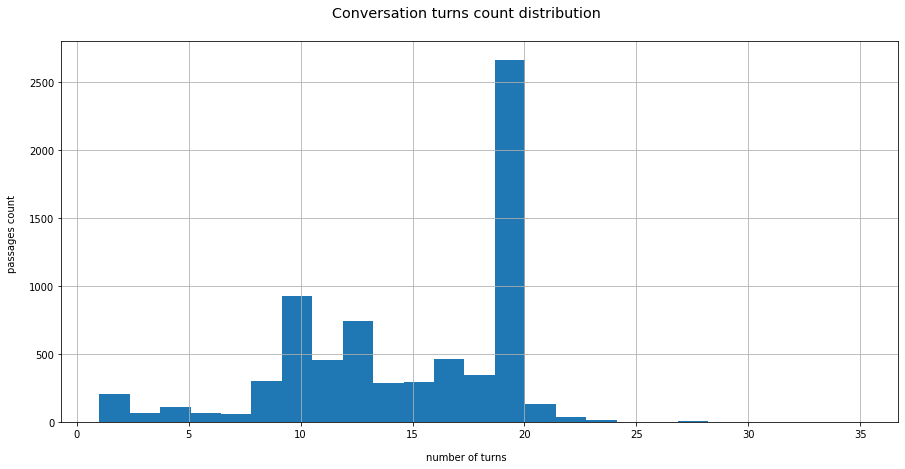

In [25]:
from utils.dataset_analisys import *
plot_converstion_length_distribution(grouped_train_df)

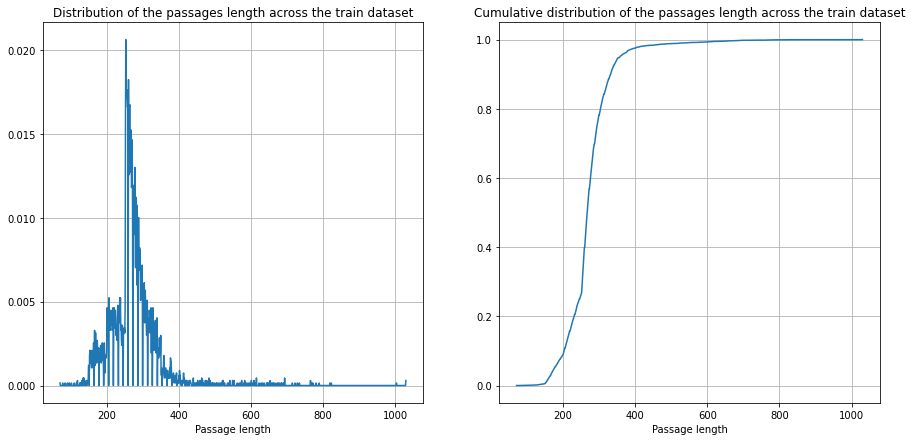

In [26]:
plot_passage_length_analysis(grouped_train_df.story.unique())

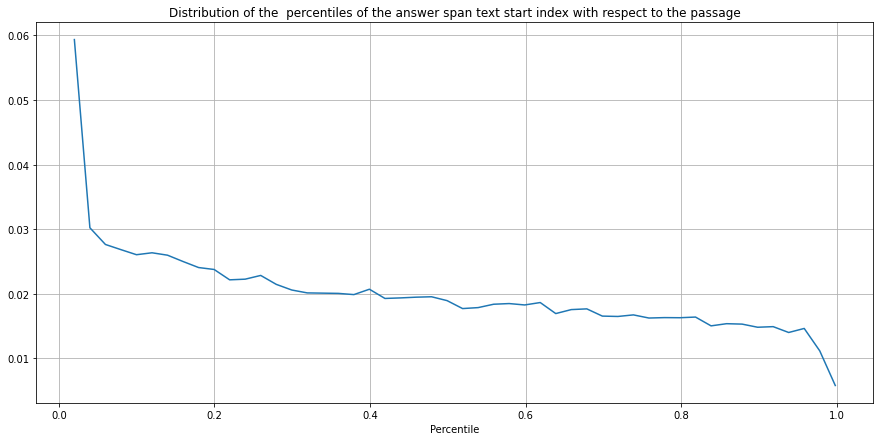

In [27]:
plot_answer_span_text_percentile(train_df)

## [Task 2] Train, Validation and Test splits

In this section the train dataframe is split into an actual train and a validation dataframes.

The split is performed as follows:
1. The random seed is set to $42$ for reproducibility purposes.
2. The train proportion of the actual training dataset to the original dataset is of $0.8$.
3. The train dataframe is shuffled and divided into the two new dataframes making sure that no conversation is split among them.

In [28]:
set_random_seed(42)

In [29]:
from sklearn.model_selection import GroupShuffleSplit
from typing import Tuple

def train_validation_split(df: pd.DataFrame, train_size: int = .8, random_seed: int = 42) \
    -> Tuple[pd.DataFrame, pd.DataFrame]:
    """ Get train and validation dataframes by shuffling and splitting an original dataframe according to a given proportion
    and a specific random seed.
    
    Note: The order of the rows of the same conversation is preserved in the shuffle. Moreover, the conversations are never
    split across the two resulting dataframes.

    Parameters
    ----------
    df : DataFrame
        The dataframe from which the train and validation dataframes are obtained.
    train_size : int, optional
        The proportion of the train split. Defaults to 0.8.
    random_seed : int, optional
        The random seed for the shuffle. Defaults to 42.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: _description_
    """
    # Get indices of train and test rows in the dataframe
    group_shuffle_split = GroupShuffleSplit(n_splits=2, train_size=train_size, random_state=random_seed)
    train_ix, test_ix = next(group_shuffle_split.split(df, groups=df.id))

    train_df = df.loc[train_ix]
    train_df.reset_index(inplace=True, drop=True)
    
    val_df = df.loc[test_ix]
    val_df.reset_index(inplace=True, drop=True)
    
    return train_df, val_df

In [30]:
train_df, val_df = train_validation_split(train_df)

The tail of the obtain dataframe (`train_df`) and the head of the validation dataframe (`val_df`) are shown below to assert that the conversations are not splitted and that their question-answer pairs are still chronologically ordered.

In [31]:
print(f'Train dataframe shape after the split: {train_df.shape}')
train_df.tail()

Train dataframe shape after the split: (85824, 10)


,source,id,story,question,answer_span_start,answer_span_end,answer_span_text,answer,turn_id,history
85819,cnn,31qnsg6a5rtt5m7pens7xklnbwf87b,(CNN) -- Cristiano Ronaldo provided the perfec...,Who was a sub?,1405,1427,substitute Xabi Alonso,Xabi Alonso,10,"[Who was in charge of FIFA?, Sepp Blatter, Wha..."
85820,cnn,31qnsg6a5rtt5m7pens7xklnbwf87b,(CNN) -- Cristiano Ronaldo provided the perfec...,Was it his first game this year?,1415,1467,Xabi Alonso made his first appearance of the ...,Yes,11,"[Who was in charge of FIFA?, Sepp Blatter, Wha..."
85821,cnn,31qnsg6a5rtt5m7pens7xklnbwf87b,(CNN) -- Cristiano Ronaldo provided the perfec...,What position did the team reach?,1520,1555,Real moved up to third in the table,third,12,"[Who was in charge of FIFA?, Sepp Blatter, Wha..."
85822,cnn,31qnsg6a5rtt5m7pens7xklnbwf87b,(CNN) -- Cristiano Ronaldo provided the perfec...,Who was ahead of them?,1557,1582,six points behind Barca.,Barca.,13,"[Who was in charge of FIFA?, Sepp Blatter, Wha..."
85823,cnn,31qnsg6a5rtt5m7pens7xklnbwf87b,(CNN) -- Cristiano Ronaldo provided the perfec...,By how much?,1557,1581,six points behind Barca.,six points,14,"[Who was in charge of FIFA?, Sepp Blatter, Wha..."


In [32]:
print(f'Validation dataframe shape after the split: {val_df.shape}')
val_df.head()

Validation dataframe shape after the split: (21452, 10)


,source,id,story,question,answer_span_start,answer_span_end,answer_span_text,answer,turn_id,history
0,cnn,3wj1oxy92agboo5nlq4r7bndc3t8a8,New York (CNN) -- More than 80 Michael Jackson...,Where was the Auction held?,243,284,Hard Rock Cafe in New York's Times Square,Hard Rock Cafe,1,[]
1,cnn,3wj1oxy92agboo5nlq4r7bndc3t8a8,New York (CNN) -- More than 80 Michael Jackson...,How much did they make?,180,210,reaping a total $2 million. \n,$2 million.,2,"[Where was the Auction held?, Hard Rock Cafe]"
2,cnn,3wj1oxy92agboo5nlq4r7bndc3t8a8,New York (CNN) -- More than 80 Michael Jackson...,How much did they expected?,292,342,"pre-sale expectations of only $120,000 in sal...","$120,000",3,"[Where was the Auction held?, Hard Rock Cafe, ..."
3,cnn,3wj1oxy92agboo5nlq4r7bndc3t8a8,New York (CNN) -- More than 80 Michael Jackson...,WHo buy the Jackson Glove,1295,1365,"Hoffman Ma, who bought the glove on behalf of ...",Hoffman Ma,4,"[Where was the Auction held?, Hard Rock Cafe, ..."
4,cnn,3wj1oxy92agboo5nlq4r7bndc3t8a8,New York (CNN) -- More than 80 Michael Jackson...,Where was the buyer of the glove from?,1331,1366,"behalf of Ponte 16 Resort in Macau,",Macau,5,"[Where was the Auction held?, Hard Rock Cafe, ..."


In [33]:
print(f'Train passages count: {len(train_df.groupby(by=["id"]))}')
print(f'Validation passages count: {len(val_df.groupby(by=["id"]))}')

print()

len_tot=len(train_df)+len(val_df)
print(f'Train QaA count: {len(train_df)} \t\t Train QaA ratio: {len(train_df)/len_tot:.2f}')
print(f'Validation QaA count: {len(val_df)} \t Validation QaA ratio: {len(val_df)/len_tot:.2f}')

Train passages count: 5754
Validation passages count: 1439

Train QaA count: 85824 		 Train QaA ratio: 0.80
Validation QaA count: 21452 	 Validation QaA ratio: 0.20


In addition, the train, validation and test dataloaders are provided for future training purposes.

In [34]:
from utils.dataloader_builder import get_dataloader

train_dataloader = get_dataloader(train_df, batch_size=8)
val_dataloader = get_dataloader(val_df)
test_dataloader = get_dataloader(test_df)

## [Task 3] Model definition
The model takes in input the question, the passage and, optionally, the history, and it generates the answer.
If given, the history is a single string where the different turns are separated with the special separator token 
`'<sep>'`. The history is used by concatenating it with the question, using the same special token `'<sep>'`, and then this concatenated
string is given in input to the model.

This model consists of two modules.
1. The first one is the **tokens importances extractor**. Given the question and the passage (and, optionally, the history)
    it produces the tokens importances: for each passage token, a score in $[0,1]$ is produced, representing the importance
    of that passage token. Basically, each score represents the likelihood that the token is in the span containing the
    answer.
2. The second module is the **encoder-decoder**, i.e. the seq2seq model. Given the question, the passage (and, optionally,
    the history) and the tokens importances, it generates the answer.

The reason for structuring in this way the model is the following. If we use only the encoder-decoder for generating the
answer, the model can have difficulties in finding the interesting and useful information in the passage, since it can 
be very long. Therefore, adding a module which gives an importance to each token, it can help the encoder-decoder in the
answer generation. Basically, the purpose is similar to have a module which extracts the span of interest from the passage
and then another module for generating an answer out of the extracted span. But the approach is different: we give an 
importance score to each passage token. 

Going more in depth, the tokens importances extractor is a transformer-based encoder (e.g. bert) with a linear layer on 
top.
Basically, for each input token, a contextual embedding vector is produced using the encoder, and then a probability score
is computed using the linear layer.

Instead, the encoder-decoder is a classic transformer-based encoder-decoder modified to make it accept the tokens importances as second input of the encoder. The importances are injected inside the model by combining them to the input hidden states of every encoder block. More precisely, for each encoder block, the tokens importances scores are transformed into vectors of the same dimensionality of the block inputs vectors using a linear layer: then, these tokens importances vectors are simply added to the block inputs vectors. We have chosen to use a different linear layer for every block of the encoder: therefore there $n$ additional linear layers, where $n$ is the number of encoder blocks.

Both the tokens importances extractor and the encoder-decoder are built from a pre-trained transformer-based architecture.
In particular, two kinds of pre-trained models can be specified.
- **Bert tiny**: `'prajjwal1/bert-tiny'`.
    The token importances extractor is built from the bert-tiny encoder; the encoder-decoder is built from the bert-tiny 
    encoder-decoder.
- **Distil roberta**: `'distilroberta-base'`.
    The token importances extractor is built from the distil roberta encoder; the encoder-decoder is built from the distil 
    roberta encoder-decoder. 

For the implementation details, see the `models/model.py` python file.

In [35]:
model_name_M1 = 'distilroberta-base'
model_name_M2 = 'prajjwal1/bert-tiny'

In [36]:
from models.model import Model 

M1 = Model(model_name=model_name_M1, device='cuda')
M2 = Model(model_name=model_name_M2, device='cuda')

Downloading:   0%|          | 0.00/480 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/316M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializin

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/285 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/16.9M [00:00<?, ?B/s]

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.predictions.

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

## [Task 4] Question generation with text passage $P$ and question $Q$

In [37]:
sample_index = 5

question_sample = [train_df.iloc[sample_index]['question']]
passage_sample = [train_df.iloc[sample_index]['story']]
answer_sample = train_df.iloc[sample_index]['answer']
history_sample = [' <sep> '.join(train_df.iloc[sample_index]['history'])]

In [38]:
print(f'Passage sample: "{passage_sample[0][:100]}..."')
print()
print(f'Question sample: "{question_sample[0]}"')
print()

questions_of_sample = train_df.iloc[sample_index]['history'][::2]
answers_of_sample = train_df.iloc[sample_index]['history'][1::2]
questions_and_answers_of_sample = [f'Q{i+1}: "{q}"; A{i+1}: "{a}"' 
                                   for i, (q, a) in enumerate(zip(questions_of_sample, answers_of_sample))]
history_string = '; '.join(questions_and_answers_of_sample)

print(f'History sample: "{history_string}"')

Passage sample: "The Vatican Apostolic Library (), more commonly called the Vatican Library or simply the Vat, is the..."

Question sample: "how do scholars divide the library?"

History sample: "Q1: "When was the Vat formally opened?"; A1: "It was formally established in 1475"; Q2: "what is the library for?"; A2: "research"; Q3: "for what subjects?"; A3: "history, and law"; Q4: "and?"; A4: "philosophy, science and theology"; Q5: "what was started in 2014?"; A5: "a  project""


In [39]:
print(f'Question sample: "{question_sample[0]}"')
print()
print(f'Predicted answer by the first model: "{M1.generate(passage_sample, question_sample)[0]}"')
print()
print(f'Predicted answer by the second model: "{M2.generate(passage_sample, question_sample)[0]}"')
print()
print(f'True answer: "{answer_sample}"')

Question sample: "how do scholars divide the library?"

Predicted answer by the first model: ".,"

Predicted answer by the second model: "mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar"

True answer: "into periods"


## [Task 5] Question generation with text passage $P$, question $Q$ and dialogue history $H$

In [40]:
print(f'Question sample: "{question_sample[0]}"')
print()
print(f'Predicted answer by the first model: "{M1.generate(passage_sample, question_sample, history=history_sample)[0]}"')
print()
print(f'Predicted answer by the second model: "{M2.generate(passage_sample, question_sample, history=history_sample)[0]}"')
print()
print(f'True answer: "{answer_sample}"')

Question sample: "how do scholars divide the library?"

Predicted answer by the first model: ".,"

Predicted answer by the second model: "mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar"

True answer: "into periods"


## [Task 6] Train and evaluate $f_\theta(P, Q)$ and $f_\theta(P, Q, H)$

Number of epochs: $3$. Batch size: $8$. Adam optimizer, with learning rate $5e-5$.

According to the fact that the model consists of two parts (i.e. the tokens importances extractor and the encoder-decoder), the loss function is the sum of two losses.
- The first loss is about the goodness of the tokens importances extractor. Basically, it measures the difference between the true span in the passage and the importances over the passage assigned by the extractor.
In particular, this loss consists in computing the binary cross-entropy, where: the true label of each passage token is 1 if that token is in the span, 0 otherwise; the predicted probability is the one assigned by the extractor.  More precisely, a variant of the binary crossentropy for imbalance classes is used, since there are much more 0 than 1.
- The second loss is about the goodness of the encoder-decoder. Basically, it measures the difference between the generated answer and the true one. This is measured using the same standard loss function of the encoder-decoder, which is the crossentropy loss.

For each training step, the loss is computed by adding these two losses on the current batch. Then, the backpropagation using this loss is performed on all the parameters of the model.

Going more in depth, the tokens importances scores given in input to the encoder-decoder module are not exactly the output computed by the extractor module, but they are a combination of the output of the extractor with the true span labels of the input tokens (i.e. each token has $1$ if its in the span, $0$ otherwise). We combine the predicted importances with the true span labels: this kind of mechanism can be seen as a teacher forcing mechanism, since we are giving the ground truth as input to the model during training.
The combination between ground truth and the output of the extractor is simply a weigthed sum. In particular, the weight related to the ground truth part (i.e. teacher forcing weight) is computed using a predefined cosine schedule, such that the weight is high at the beginning of the training and then it is gradually decreased. The reasons of using this approach are the following.
- At the beginning of the training, when the extractor has not learned anything yet, passing the importances calculated by the extractor module to the encoder-decoder module is useless: it is better to train the encoder-decoder using as inputs the actual targets of the extractor.
- On the other hand, training the encoder-decoder only using perfect importances does not prepare it to the actual task where it has to use the predicted importances, so at the end would be better to use the predicted importances instead. Furthermore, using the output of the extractor as input for the encoder-decoder allows the gradient to flow between the two, potentially teaching the extractor to find more information than just the importances.
- Finally, turning off abruptly the supervision would introduce a discontinuity that could potentially arm the training, so instead we computed the importances in input for the encoder-decoder as a linear combination of the prediction and the target, and turn off the supervision gradually (following a cosine function).

For more details, see the `utils/training.py` python file.

### 6.1 distilroberta-base

In [41]:
# Set the seed for reproducibility (options: 42; 2022; 1337)
seed_M1 = 2022
# Set whether to use history or not
use_history_M1 = True

In [42]:
from utils.checkpoint_loader import get_checkpoint_path, load_checkpoints

checkpoint_path_M1 = get_checkpoint_path(model_name_M1, seed_M1, use_history_M1)

# Reinitialize the model with the set random seed
set_random_seed(seed_M1)
M1 = Model(model_name=model_name_M1, device='cuda')

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializin

In [43]:
loss_history, val_loss_history, optimizer_state_dict = load_checkpoints(M1, checkpoint_path_M1)

Unable to load saved files, default initialization


In [44]:
from utils.training import train

set_random_seed(seed_M1)
train(train_dataloader=train_dataloader, val_dataloader=val_dataloader, epochs=3, model=M1, use_history=use_history_M1, 
      checkpoint_path=checkpoint_path_M1, loss_history = list(loss_history) if loss_history is not None else None,
      val_loss_history=list(val_loss_history) if loss_history is not None else None, steps_validate=0.33, steps_save=0.1,
      device='cuda')

'epoch: 1/3, 10728/10728, 6901s 643ms/step, lr: 5e-05, forcing=0.75, loss: 0.463 1.74'

'epoch: 2/3, 10728/10728, 6898s 643ms/step, lr: 5e-05, forcing=0.25, loss: 0.327 0.745'

'epoch: 3/3, 10728/10728, 6915s 645ms/step, lr: 5e-05, forcing=2.38e-09, loss: 0.288 0.594'

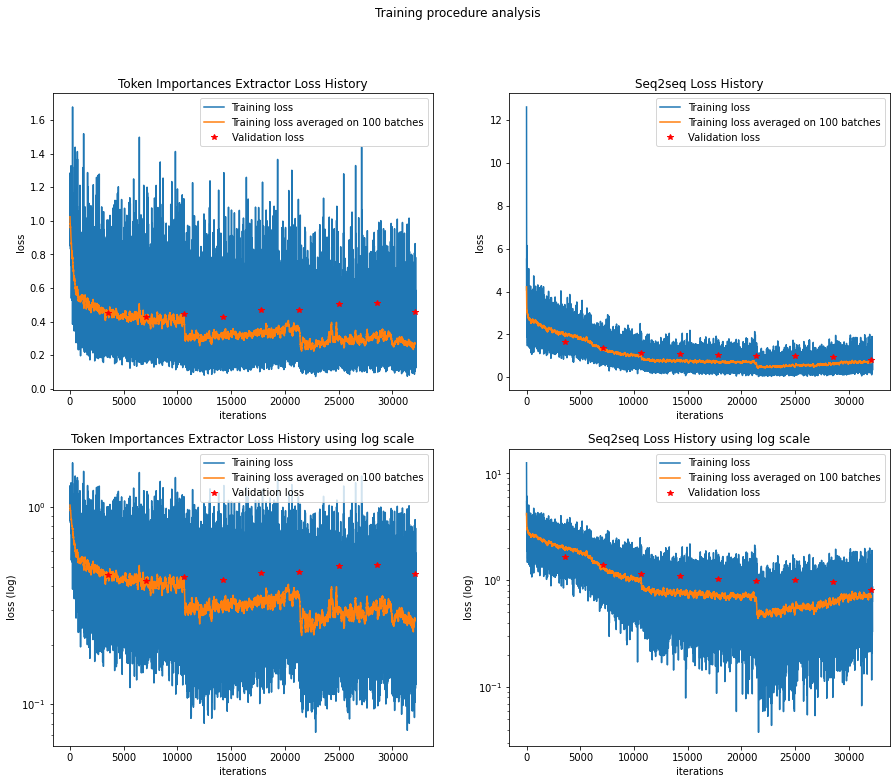

In [45]:
from utils.train_analysis import plot_training_history
plot_training_history(checkpoint_path_M1)

In [46]:
from utils.squad import validate
f1_squad = validate(M1, val_dataloader, use_history=use_history_M1)
print(f'Mean SQuAD F1-score on the validation set of the "distilroberta-base" model: {f1_squad}')
print()
f1_squad = validate(M1, test_dataloader, use_history=use_history_M1)
print(f'Mean SQuAD F1-score on the test set of the "distilroberta-base" model: {f1_squad}')

Mean SQuAD F1-score on the validation set of the "distilroberta-base" model: 0.5028064156884385

Mean SQuAD F1-score on the test set of the "distilroberta-base" model: 0.5234226971019368


#### 6.1.1 Results

##### Validation mean SQuAD F1-score summary

|               |   No-History    | History         |
| :------------ | :-------------: | :--------------:|
|   seed 42     | 0.48132         | 0.49752         |
|   seed 2022   | 0.47511         | 0.50281         |
|   seed 1337   | 0.44120         | 0.48739         |

##### Test mean SQuAD F1-score summary

|               |   No-History    | History         |
| :------------ | :-------------: | :--------------:|
|   seed 42     | 0.49185         |  0.51392        |
|   seed 2022   | 0.49350         |  0.52342        |
|   seed 1337   | 0.44890         |  0.51066        |

Given the results, it is evident how the use of the Question and Answer history to generate the next answer increases the performances as the model is able to build a context even for questions of an ongoing conversation.

### 6.2 prajjwal1/bert-tiny

In [47]:

# Set the seed for reproducibility (options: 42; 2022; 1337)
seed_M2 = 2022
# Set whether to use history or not
use_history_M2 = False

In [48]:
from utils.checkpoint_loader import get_checkpoint_path, load_checkpoints

checkpoint_path_M2 = get_checkpoint_path(model_name_M2, seed_M2, use_history_M2)

# Reinitialize the model with the set random seed
set_random_seed(seed_M2)
M2 = Model(model_name=model_name_M2, device='cuda')


Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.predictions.

In [49]:
loss_history, val_loss_history, optimizer_state_dict = load_checkpoints(M2, checkpoint_path_M2)

Unable to load saved files, default initialization


In [50]:
from utils.training import train

set_random_seed(seed_M2)
train(train_dataloader=train_dataloader, val_dataloader=val_dataloader, epochs=3, model=M2, use_history=use_history_M2, 
      checkpoint_path=checkpoint_path_M2, loss_history = list(loss_history) if loss_history is not None else None,
      val_loss_history=list(val_loss_history) if loss_history is not None else None, steps_validate=0.33, 
      steps_save=0.1, device='cuda')

'epoch: 1/3, 10728/10728, 601s 56ms/step, lr: 5e-05, forcing=0.75, loss: 0.922 1.89'

/kaggle/working/NLP-assignment-2/models/encoder_decoder_bertTiny.py:103: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


'epoch: 2/3, 10728/10728, 605s 56ms/step, lr: 5e-05, forcing=0.25, loss: 0.778 1.29'

'epoch: 3/3, 10728/10728, 605s 56ms/step, lr: 5e-05, forcing=2.38e-09, loss: 0.718 1.26'

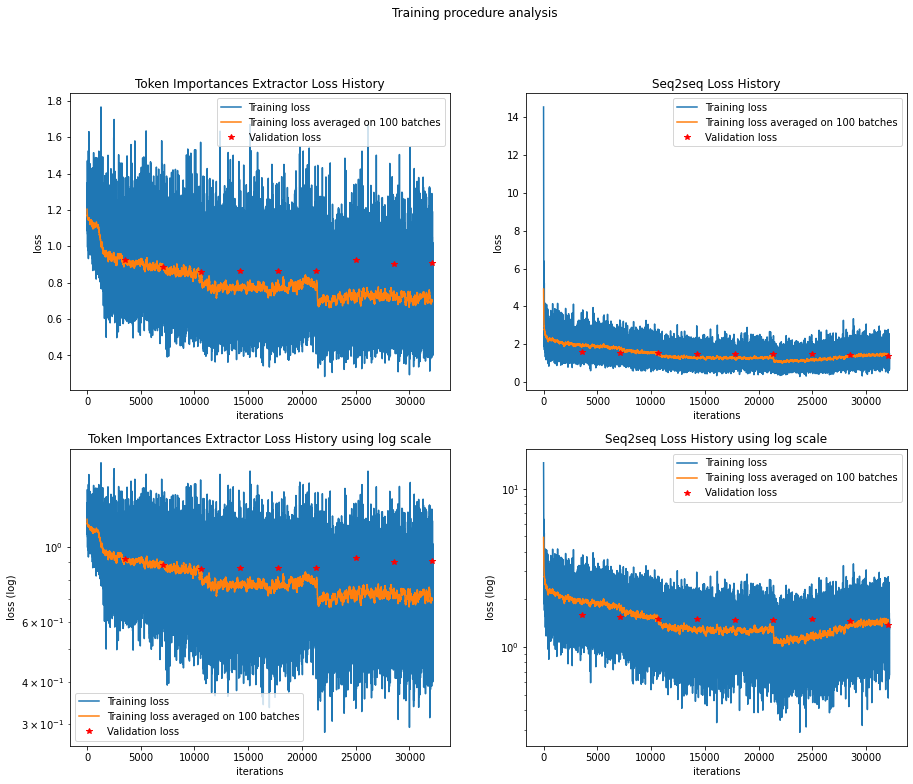

In [51]:
from utils.train_analysis import plot_training_history
plot_training_history(checkpoint_path_M2)

In [52]:
from utils.squad import validate
f1_squad = validate(M2, val_dataloader, use_history=use_history_M2)
print(f'Mean SQuAD F1-score on the validation set of the "bert-tiny" model: {f1_squad}')
print()
f1_squad = validate(M2, test_dataloader, use_history=use_history_M2)
print(f'Mean SQuAD F1-score on the test set of the "bert-tiny" model: {f1_squad}')

Mean SQuAD F1-score on the validation set of the "bert-tiny" model: 0.24117421818765528

Mean SQuAD F1-score on the test set of the "bert-tiny" model: 0.2460969795446573


#### 6.2.1 Results

##### Validation mean SQuAD F1-score summary

|               |   No-History    | History         |
| :------------ | :-------------: | :--------------:|
|   seed 42     | 0.23645         | 0.22185         |
|   seed 2022   | 0.24117         | 0.23626         |
|   seed 1337   | 0.24062         | 0.23203         |

##### Test mean SQuAD F1-score summary

|               |   No-History    | History         |
| :------------ | :-------------: | :--------------:|
|   seed 42     | 0.23854         | 0.23488         |
|   seed 2022   | 0.24610         | 0.24361         |
|   seed 1337   | 0.25225         | 0.23502         |

Given the results, it is evident how the use of the Question and Answer history to generate the next answer worsen the performances. The reason behind this behaviour can probably be found in the fact that the `prajjwal1/bert-tiny` model is less proficient and more lightweight than the `distilroberta-base` one, hence the addition of the history may result in harder inputs to analyse and worst performances.

## [Task 7] Error Analysis

The error analysis is performed on both the `distilroberta-base` and `prajjwal1/bert-tiny` models while considering the combination of the two hyperparameters `seed` and `use_history` that led to the best *SQuAD F1* scores on the validation dataset, namely:
* `distilroberta-base`
    * `seed = 2022`
    * `use_history = True`
* `prajjwal1/bert-tiny`
    * `seed = 2022`
    * `use_history = False`

The error analysis is performed on the test dataset, while considering the worst $5$ errors in generating the answers according to the *SQuAD F1* score for each source.

The errors are analysed by taking into account the considerations expressed in the paper [*CoQA: A Conversational Question Answering Challenge*](https://arxiv.org/pdf/1808.07042.pdf).

In [44]:
grouped_test_df = test_df.groupby(by=['source'])
print(f'Number of sources: {len(grouped_test_df)}')
print(f'Source names: {"; ".join([key for key, _ in grouped_test_df])}.')

Number of sources: 5
Source names: cnn; gutenberg; mctest; race; wikipedia.


### 7.1 distilroberta-base

The error analysis is firstly performed on the `distilroberta-base` model.

In [45]:
from models.model import Model 
from utils.checkpoint_loader import get_checkpoint_path, load_checkpoints

# Remove previous tensors from GPU memory
torch.cuda.empty_cache()

best_seed_M1 = 2022
use_history_M1 = True
best_checkpoints_path_M1 = get_checkpoint_path(model_name_M1, best_seed_M1, use_history_M1)


set_random_seed(best_seed_M1)
best_M1 = Model(model_name=model_name_M1, device='cuda')

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializin

In [46]:
loss_history, val_loss_history, optimizer_state_dict = load_checkpoints(best_M1, best_checkpoints_path_M1)

Loaded saved files


The $5$ worst answers are obtained for each source.

In [47]:
from utils.error_analysis import get_worst_answers, show_worst_errors, plot_token_importances

sources_statistics_dict = dict()
for source, df_source in grouped_test_df:
    sources_statistics_dict[source] = get_worst_answers(best_M1, df_source, use_history=use_history_M1)

100%|██████████| 101/101 [01:41<00:00,  1.00s/it]


#### 7.1.1 CNN

In [48]:
show_worst_errors('cnn', sources_statistics_dict)

* Passage span: A Barcelona member launched a case against Rosell for not disclosing the full details
* Question: "A Barcelona member launched a case against who?"
* Gold Answer: "Rosell"
* Predicted Answer: "Vera Zvonareva"
* F1 SQuAD: 0.0

* Passage span: The country now wants to step up airstrikes against the terrorist organization
* Question: "A source mentioned that Jordan will use what against the terrorists?"
* Gold Answer: "airstrikes."
* Predicted Answer: "Borrowers"
* F1 SQuAD: 0.0

* Passage span: there have been ongoing efforts -- from awards to statues to new songs -- to keep his memory,
* Question: "After death was he forgotten?"
* Gold Answer: "No!"
* Predicted Answer: "yes"
* F1 SQuAD: 0.0

* Passage span: Next, Neroy created a shared color board 
* Question: "After that?"
* Gold Answer: "a shared color board"
* Predicted Answer: "yes"
* F1 SQuAD: 0.0

* Passage span: 12.3 deaths per 100,000. 
* Question: "And in 2011?"
* Gold Answer: "12.3 deaths per 100,000."
* Predic

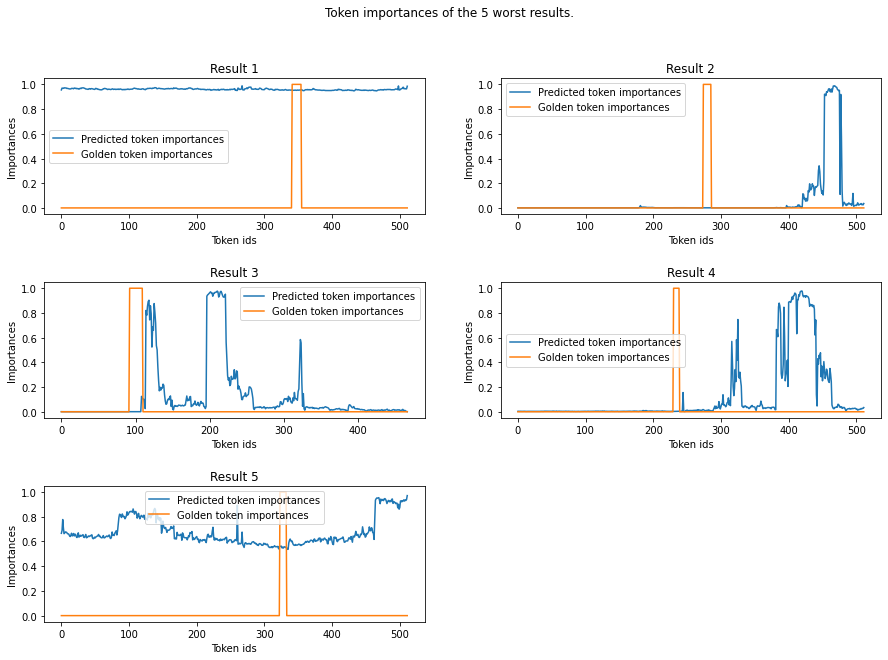

In [49]:
plot_token_importances('cnn', sources_statistics_dict, best_M1, use_history=use_history_M1)

All the worst errors of the generated answers for the `CNN` source can be connected to an incorrect assignment of the tokens importances during the *Token Importances Extractor* execution of the model.

1. It is worth noticing that for the first example the importances of the tokens are equally distributed for the whole passage, therefore the generated answer could be considered similar to a guess. Nonetheless, a person name is returned, which is coherent to the kind of pondered question.

Regarding the second, third and fourth worst result, it is evident that the extracted importances are completely off, as the rationale in the passage is skipped altogether in all the cases. In deeper detail:

2. The kind of error in the second answer is similar to the one of the first one, as a different noun is returned instead of the correct one.
3. The error in the third answer can be seen as a choice mismatch. The natural answer to the given question is either "yes" or "no" and the model outputed the incorrect choice. It is worth pointing out that according to the paper, "yes" and "no" answer are one of the most common kind of answer which do not overlap with the rationale in the passage ($78.8\%$ of the answer types). Despite the error, the model managed to correctly classify the kind of answer that was asked.
4. The fourth answer error is slightly different than the previous one. The expected answer refers the name of an object, while the model simply returns the answer "yes". Even if incorrect, the kind of given answer could be feasible for the kind of pondered question if taken out of context.

5. Finally, for the last result, the importances of the tokens are once again assigned mistakenly. It is interesting to point out that the least important tokens for the model are instead the ones of the rationale. The given answer is once again feasible with respect to the question considered out of conext.

#### 7.1.2 Gutenberg

In [50]:
show_worst_errors('gutenberg', sources_statistics_dict)

* Passage span: Donovan
* Question: "According to who?"
* Gold Answer: "Donovan"
* Predicted Answer: "Mr. Wright"
* F1 SQuAD: 0.0

* Passage span: at least the tenth time
* Question: "After how many times?"
* Gold Answer: "at least ten"
* Predicted Answer: "twice"
* F1 SQuAD: 0.0

* Passage span: He might dog Marcus
* Question: "Against who?"
* Gold Answer: "Marcus"
* Predicted Answer: "Caleb"
* F1 SQuAD: 0.0

* Passage span: After going over the main island of Poloe 
* Question: "An insignificant one?"
* Gold Answer: "the main one"
* Predicted Answer: "no"
* F1 SQuAD: 0.0

* Passage span: Link Merwell
* Question: "And Merwell's?"
* Gold Answer: "Link"
* Predicted Answer: "Petsy"
* F1 SQuAD: 0.0



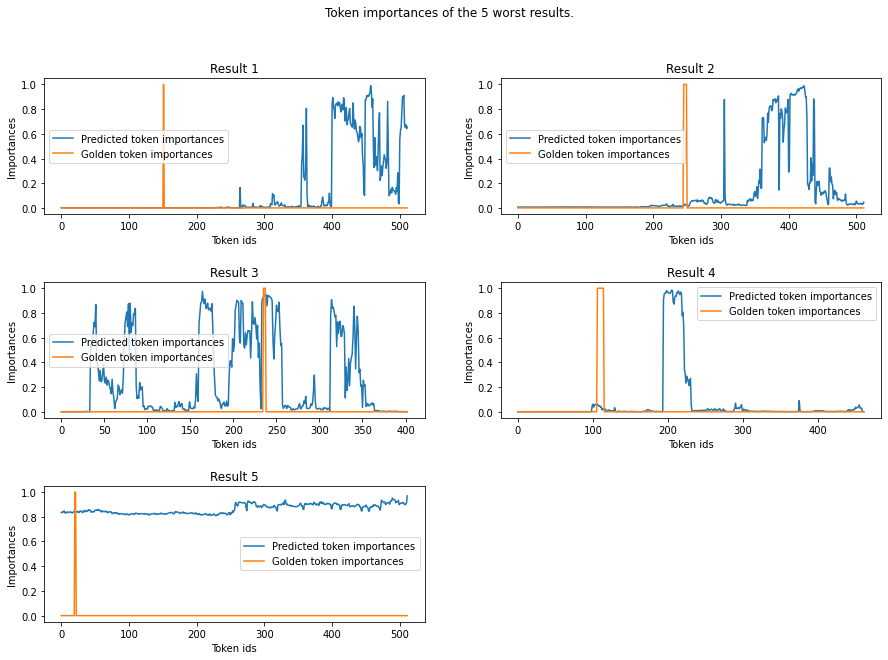

In [51]:
plot_token_importances('gutenberg', sources_statistics_dict, best_M1, use_history=use_history_M1)

The worst errors for the source `Gutenberg` are similar to the ones of the previous source `CNN`.
The first, second and fourth results are due to the model missing the correct importances of the tokens of the rationale. On the other hand, on the third result, the model manages to assign proper importance to the tokens of the rationale in the original passage, however a high importance is given even to a lot of other tokens in the passage. The final result token importances assignment error is similar to the first of the previous source as all the tokens are given roughly the same importance.

Regarding the kind of obtained errors:
1. The model recognizes the fact that a person name should be provided as an answer, although an incorrect one that is still present in the passage is given. The correct answer is strongly dependant on the history of the conversation.
2. A *counting* related answer that does not fully overlap with the passage is required to be obtained by paraphrasing the rationale. The model manages to understand that a count should be provided, although an incorrect one is outputed. The *counting* kind of answer constitute the $5.1\%$ of the *free-form answer* cases according to the experiment of the paper.
3. The error is similar to the first one.
4. The model answers "no" to the question "An insignificant one?", while the expected answer was "the main one", referred to the islands of the Poloe. Nonetheless, the answer provided by the model can be still considered valid even if not as detailed as the correct one. As illustrated by the token importances extractor chart, a small importance is given to the tokens of the rationale, possible reason why the model managed to find a correct (even if not expected) answer to the question.
5. The error in the final result is once again similar to the first and third one.

#### 7.1.3 McTest

In [52]:
show_worst_errors('mctest', sources_statistics_dict)

* Passage span: She wrote one about her & Eduardo!
* Question: "About what?"
* Gold Answer: "her & Eduardo"
* Predicted Answer: "snowy-cringes."
* F1 SQuAD: 0.0

* Passage span: fixed the four of them made a delicious dinner and talked about all of the good work that they had done
* Question: "After completing the repairs what did everyone do?"
* Gold Answer: "Made dinner."
* Predicted Answer: "He pushed the window."
* F1 SQuAD: 0.0

* Passage span: Then remember the most happy you have ever felt!
* Question: "And then do what?"
* Gold Answer: "remember the happiest she ever felt"
* Predicted Answer: "I don't feel happy with you."
* F1 SQuAD: 0.0

* Passage span: seeds
* Question: "And what about the seed?"
* Gold Answer: "yes"
* Predicted Answer: "thick"
* F1 SQuAD: 0.0

* Passage span: Her Mom said she could try to play with her sister, but that only made her baby sister cry louder.
* Question: "And what was the first thing she tried?"
* Gold Answer: "She played with her."
* Predicte

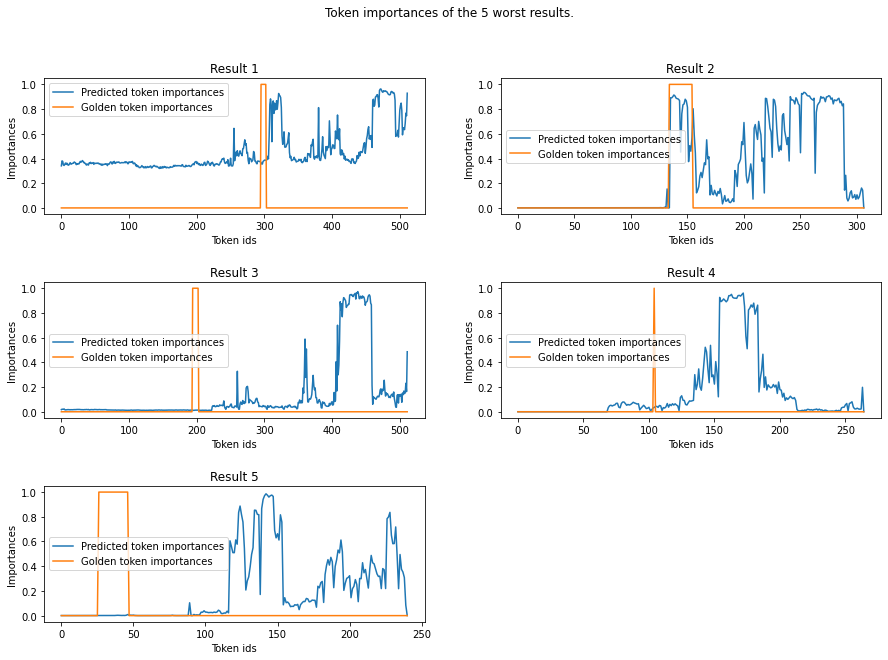

In [53]:
plot_token_importances('mctest', sources_statistics_dict, best_M1, use_history=use_history_M1)

Regarding the *Token Importances Extractor* outcomes for the source `McTest`, once again, for most results the wrong tokens are given fairly more importance than the ones of the rationale. The sole exception relates to the second result, where the tokens of the rationale are given proper high importance. Nonetheless, even other non interesting tokens are considered important in this case.

The errors for this source are qualitatively worse than the ones of the previous sources:
1. In the first result, once again a wrong noun is provided as an answer.
2. An incorrect action is given as an answer. The model does not manage to recognize the fact that the question concerns an inquire about what *multiple people* ("everyone") did after a previous action and it returned another action in the passage that a *single person* ("he") performed.
3. The model is completely off this time, giving a kind of answer that is completely incoherent with the question.
4. A description of the object presented in the question was provided by the model. Although the answer "yes" was expected. It is worth noticing that the given answer can be considered feasible out of context and that the given rationale does not seem informative to produce the actual answer.
5. A description of an action is supposed to be the answer to the question like in the second result. It should be obtained by paraphrasing the rationale. Nonetheless the model manages to understand that, the response is incorrect.

#### 7.1.4 Race

In [54]:
show_worst_errors('race', sources_statistics_dict)

* Passage span:  Luke Tipple
* Question: "According to who?"
* Gold Answer: "Luke Tipple"
* Predicted Answer: "Many species are at risk of extinction"
* F1 SQuAD: 0.0

* Passage span:  It was Mrs. Fern.
* Question: "According to whom?"
* Gold Answer: "Mrs. Fern."
* Predicted Answer: "the officer"
* F1 SQuAD: 0.0

* Passage span: according to Garcia's mom
* Question: "According to whom?"
* Gold Answer: "Garcia's mom"
* Predicted Answer: "American Music Therapy Association"
* F1 SQuAD: 0.0

* Passage span: "It's 8:15 on a Sunday morning
* Question: "Am or pm?"
* Gold Answer: "morning"
* Predicted Answer: "8:15"
* F1 SQuAD: 0.0

* Passage span: a square
* Question: "And four?"
* Gold Answer: "a square"
* Predicted Answer: "a third person"
* F1 SQuAD: 0.0



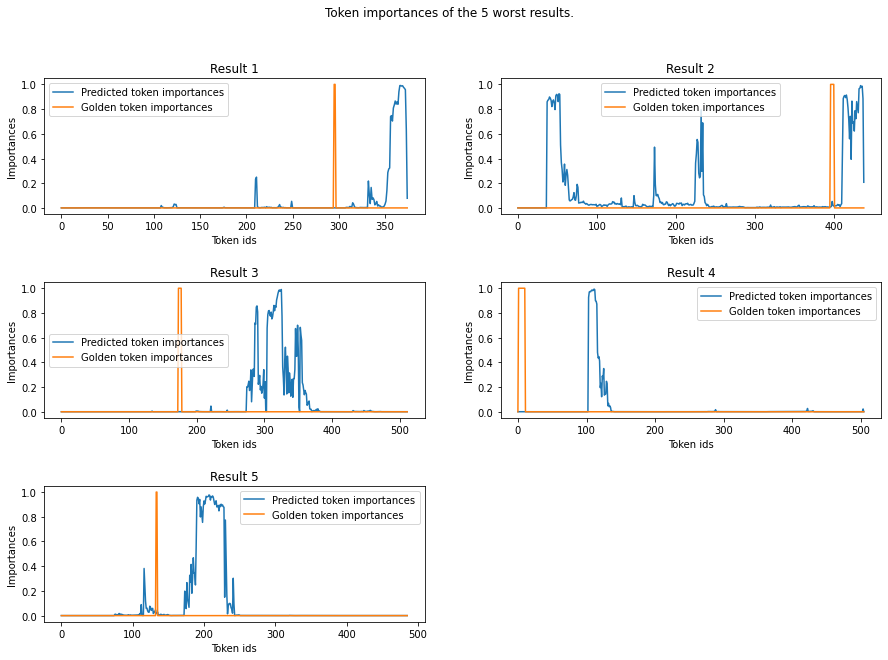

In [55]:
plot_token_importances('race', sources_statistics_dict, best_M1, use_history=use_history_M1)

The *Token Importances Extractor* errors of the worst `Race` source results, are all related to the fact that no importance is given to the actual tokens of the rationales in the passages.

The errors for this source are interesting:
* (1-2-3) The same error is committed for the first three results. In particular, the question "According to who/whom?" is asked and a wrong answer is provided. While in the second and third case a wrong but possibly feasible subject is generated, in the first result the model is completely off and it gives an output which is totally unrelated to the question. 
4. The model is required to perform a choice from the question "Am or pm?". According to the paper, this kind of expected answer composes around the $1.8\%$ of the *free-form answers*. The provided result is not the expected one, however the answer cannot be totally deemed as incorrect because instead of the expected answer "morning" a precise time is provided ("8:15").
5. An incorrect noun is given as an answer like in previous cases.

#### 7.1.5 Wikipedia

In [56]:
show_worst_errors('wikipedia', sources_statistics_dict)

* Passage span: and "dēmos" meaning "the people"
* Question: "And "demos"?"
* Gold Answer: ""the people""
* Predicted Answer: "Dēmos"
* F1 SQuAD: 0.0

* Passage span: calibration of acoustic equipment and the tuning of pianos, violins, and other musical instruments. 
* Question: "And another?"
* Gold Answer: "violins"
* Predicted Answer: "violin"
* F1 SQuAD: 0.0

* Passage span: Sleswig-Holsteen
* Question: "And the Low German name for it?"
* Gold Answer: "Sleswig-Holsteen"
* Predicted Answer: "Sleswig-Holstein"
* F1 SQuAD: 0.0

* Passage span: Slaswik-Holstiinj
* Question: "And the North Frisian name?"
* Gold Answer: "Slaswik-Holstiinj"
* Predicted Answer: "Slaswiki-Holstiin"
* F1 SQuAD: 0.0

* Passage span:  led to World War II and the Holocaust.
* Question: "And the second?"
* Gold Answer: "The Holocaust."
* Predicted Answer: "World War II."
* F1 SQuAD: 0.0



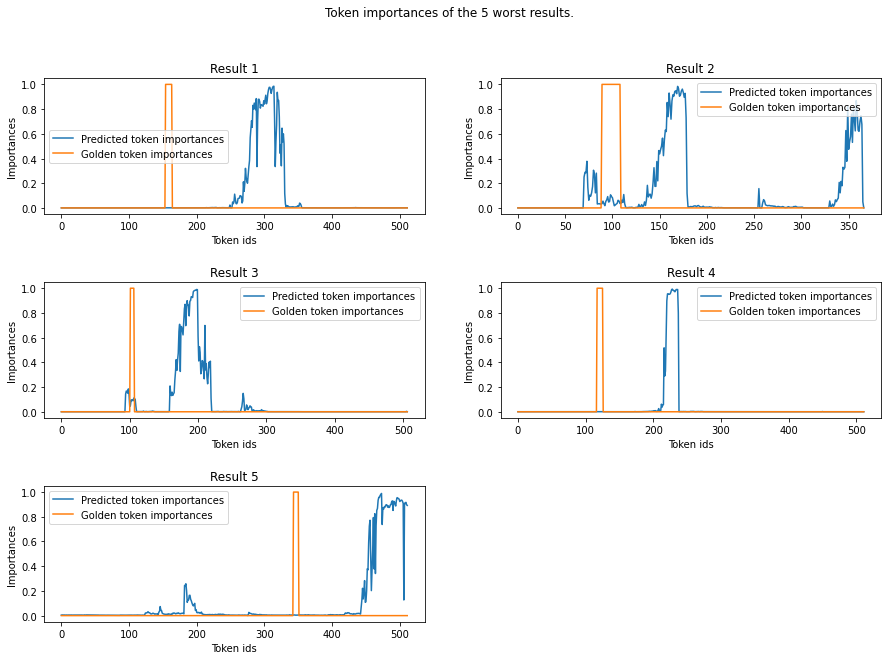

In [57]:
plot_token_importances('wikipedia', sources_statistics_dict, best_M1, use_history=use_history_M1)

Finally, regarding the worst `Wikipedia` source results, the errors are related once again to the fact that no or low importance is given to the actual tokens of the respective rationales.

The worst errors for this source are not particularly far from the true answers:
1. In the first result, the provided answer is somewhat linked to the actual one, although it is incorrect.
2. The model manages to identify a correct answer, although it does not understand that the name of the object that is provided as an answer should have been put in the singular form as a plural version is obtained.
* (3-4) The errors of the third and fourth examples are of the the same kind and are from the same passage. In both cases, the model is asked to answer with a variation of the name of two person in a different language/dialect. The model itself gets close to the true answers although it provides the wrong name variations among the two possible choices.
5. Once again the model is asked to answer by selecting between two choices which are not directly expressed in the question itself, but in the rationale. The error is that the model considers the wrong answer between the two possible ones.

#### 7.1.6 Recap

The model `distilroberta-base` is particularly good even in the worst cases. The less satisfactory results refer to the source `McTest`, while the ones of the other sources are less serious. 

Some of the errors are just an interpretation which is correct, although different from the expected one. The majority of the errors are either a wrong choice between multiple possibilities or incorrect answers that are still valid out of context for the given questions.

On that last point, it is important to notice that most of the errors are obtained from questions that are pondered in an already enstablished conversation and are therefore harder to adapt in a context.

### 7.2 prajjwal1/bert-tiny

Finally, the error analysis is performed on the `prajjwal1/bert-tiny` model.

Differently from `distilroberta-base`, the *Token Importances Extractor* assignment of the importance factor to the tokens of the passage is generally pretty erratic and not really interesting to analyse. Unless some interesting fact needs to be pointed out the results of the assignment of the importances of the tokens won't be discussed.

Moreover, this model does not use the history of the conversation to generate the answer to a question, hence it is expected to perform worse to output results for ongoing conversations.

In [58]:
from models.model import Model 
from utils.checkpoint_loader import get_checkpoint_path, load_checkpoints

# Remove previous tensors from GPU memory
torch.cuda.empty_cache()

best_seed_M2 = 2022
use_history_M2 = False
best_checkpoints_path_M2 = get_checkpoint_path(model_name_M2, best_seed_M2, use_history_M2)


set_random_seed(best_seed_M2)
best_M2 = Model(model_name=model_name_M2, device='cuda')

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.predictions.

In [59]:
loss_history, val_loss_history, optimizer_state_dict = load_checkpoints(best_M2, best_checkpoints_path_M2)

Loaded saved files


The $5$ worst answers are obtained for each source.

In [60]:
from utils.error_analysis import get_worst_answers, show_worst_errors, plot_token_importances

sources_statistics_dict = dict()
for source, df_source in grouped_test_df:
    sources_statistics_dict[source] = get_worst_answers(best_M2, df_source, use_history=use_history_M2)

  0%|          | 0/103 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/transformers/generation/utils.py:1387: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|██████████| 101/101 [00:20<00:00,  5.04it/s]


#### 7.2.1 CNN

In [61]:
show_worst_errors('cnn', sources_statistics_dict, show_history=use_history_M2)

* Passage span: The country now wants to step up airstrikes against the terrorist organization
* Question: "A source mentioned that Jordan will use what against the terrorists?"
* Gold Answer: "airstrikes."
* Predicted Answer: "yes"
* F1 SQuAD: 0.0

* Passage span: The motorcade was not hit and there were no injuries, the Georgian Interior Ministry said
* Question: "According to whom?"
* Gold Answer: "Georgian Interior Ministry"
* Predicted Answer: "russian"
* F1 SQuAD: 0.0

* Passage span: across the Pacific
* Question: "Across what ocean?"
* Gold Answer: "the Pacific"
* Predicted Answer: "miles"
* F1 SQuAD: 0.0

* Passage span: Next, Neroy created a shared color board 
* Question: "After that?"
* Gold Answer: "a shared color board"
* Predicted Answer: "yes"
* F1 SQuAD: 0.0

* Passage span:  in what has been described as a road rage incident that ended a week ago 
* Question: "After what?"
* Gold Answer: "a road rage incident"
* Predicted Answer: "the investigation"
* F1 SQuAD: 0.0



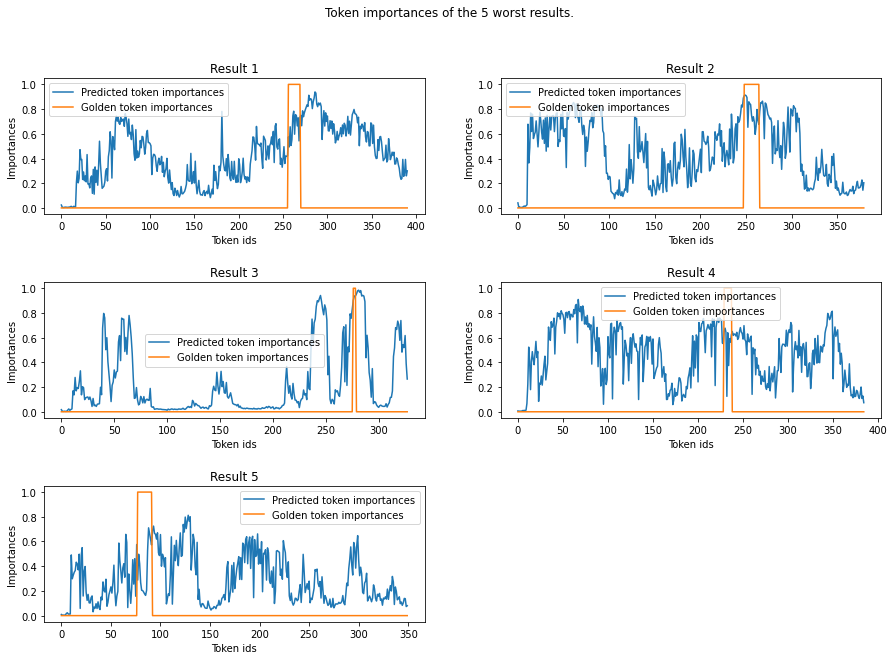

In [62]:
plot_token_importances('cnn', sources_statistics_dict, best_M2, use_history=use_history_M2)

For the `CNN` source the following errors occur:
1. The answer "yes" is provided, while the kind of answer expected for the question was a noun. It is important to remind that according to the paper, "yes" and "no" answer are one of the most common kind of answer which do not overlap with the rationale in the passage ($78.8\%$ of the answer types). Due to the lower complexity of the model with respect to `distilroberta-base` and the lack of usage of the conversation history, This kind of error is expected to be more frequent and not consistent with the provided question. In this specific case, a "yes/no" answer is completely out of context.
2. A wrong noun is provided as an answer. Grammatically speaking, the response is not consistent with the kind of question.
3. Like in the previous case, a wrong and inconsistent answer is provided.
4. The answer "yes" is once again outputed by the model. This time this kind of answer could be considered feasible out of context and in relation to the question.
5. A wrong answer is obtained, however out of context it may be considered a feasible answer to the given question.

#### 7.2.2 Gutenberg

In [63]:
show_worst_errors('gutenberg', sources_statistics_dict, show_history=use_history_M2)

* Passage span: Donovan
* Question: "According to who?"
* Gold Answer: "Donovan"
* Predicted Answer: "bill"
* F1 SQuAD: 0.0

* Passage span: at least the tenth time
* Question: "After how many times?"
* Gold Answer: "at least ten"
* Predicted Answer: "three"
* F1 SQuAD: 0.0

* Passage span: Thayer
* Question: "Along with who?"
* Gold Answer: "Thayer"
* Predicted Answer: "harriet"
* F1 SQuAD: 0.0

* Passage span: Link Merwell
* Question: "And Merwell's?"
* Gold Answer: "Link"
* Predicted Answer: "yes"
* F1 SQuAD: 0.0

* Passage span: he might still win Miriam
* Question: "And her name?"
* Gold Answer: "Miriam"
* Predicted Answer: "yes"
* F1 SQuAD: 0.0



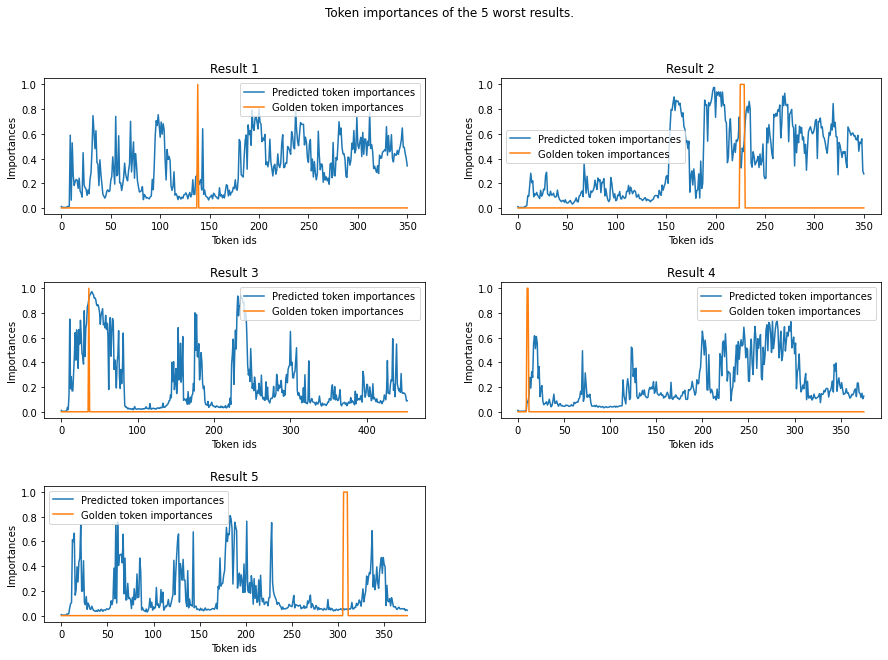

In [64]:
plot_token_importances('gutenberg', sources_statistics_dict, best_M2, use_history=use_history_M2)

For the `Gutenberg` source the errors are more forgiveable than in the previous case:
1. The question required to output a name of a person as an answer and the model did so, although returning a wrong one.
2. A *counting* value was expected as an answer and the model managed to understand so, although providing a wrong result. It is important to remind that answers related to *counting* constitute the $5.1\%$ of the *free-form answer* cases according to the experiment of the paper.
3. An error similar to the one of the first result is obtained.
4. Again, "yes" is outputed by the model. The answer could be considered feasible out of context and in relation to the question.
5. A similar error to the one of the fourth result is obtained.

#### 7.2.3 McTest

In [65]:
show_worst_errors('mctest', sources_statistics_dict, show_history=use_history_M2)

* Passage span: Snow meets me at the door. He is so happy to see me. I am happy to see him, too! 
* Question: "Am I sad to see him?"
* Gold Answer: "no"
* Predicted Answer: "yes"
* F1 SQuAD: 0.0

* Passage span: Jessica got up and walked to the drier
* Question: "And after that?"
* Gold Answer: "she walked to the drier"
* Predicted Answer: "yes"
* F1 SQuAD: 0.0

* Passage span: so he pushed the boy over 
* Question: "And did what?"
* Gold Answer: "He pushed the boy"
* Predicted Answer: "a teacher"
* F1 SQuAD: 0.0

* Passage span: Then remember the most happy you have ever felt!
* Question: "And then do what?"
* Gold Answer: "remember the happiest she ever felt"
* Predicted Answer: "the star"
* F1 SQuAD: 0.0

* Passage span: seeds
* Question: "And what about the seed?"
* Gold Answer: "yes"
* Predicted Answer: "strawberries"
* F1 SQuAD: 0.0



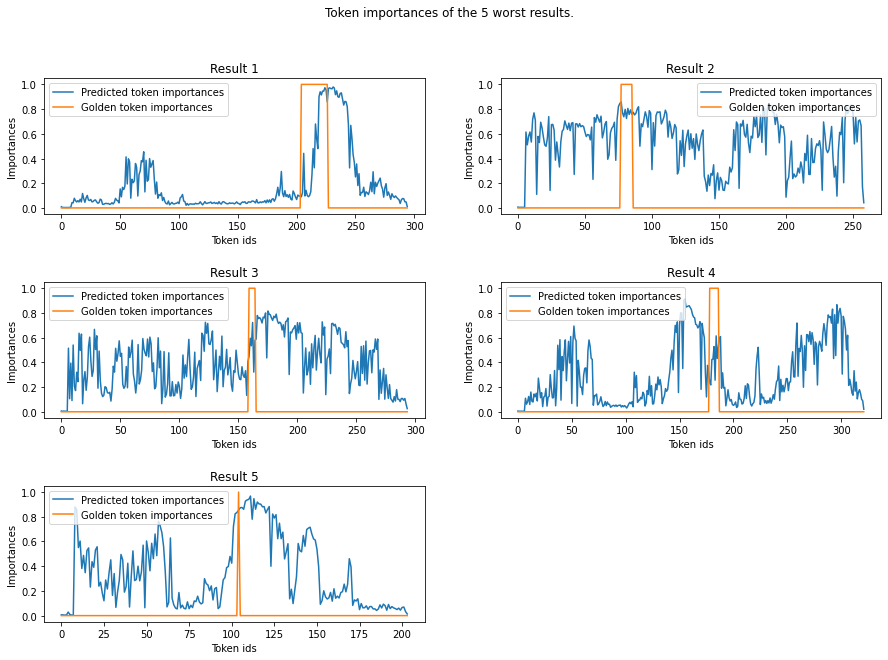

In [66]:
plot_token_importances('mctest', sources_statistics_dict, best_M2, use_history=use_history_M2)

For the `McTest` source the errors are the following:
1. The model had to make a choice between a "yes/no" answer. It managed to grasp that, but unfortunately it outputed the wrong choice. It's interesting to point out that in this case the *Token Importances Extractor* managed to assign higher importance to some tokens of the rationale.
2. Again, "yes" is outputed by the model. The answer could be considered feasible out of context and in relation to the question.
3. The expected answer was an action while the model returned a noun making the answer inconsistent with the question even out of context.
4. A similar error to the one of the third result is obtained.
5. A similar error to the one of the second result is obtained.

#### 7.2.4 Race

In [67]:
show_worst_errors('race', sources_statistics_dict, show_history=use_history_M2)

* Passage span: Babette Renneberg
* Question: "According to whom?"
* Gold Answer: "Babette Renneberg"
* Predicted Answer: "paul"
* F1 SQuAD: 0.0

* Passage span: After each of the two world wars, musicians visited hospitals
* Question: "After what wars did musicians start visiting hospitals?"
* Gold Answer: "WWI and WWII"
* Predicted Answer: "the world"
* F1 SQuAD: 0.0

* Passage span: "It's 8:15 on a Sunday morning
* Question: "Am or pm?"
* Gold Answer: "morning"
* Predicted Answer: "old man"
* F1 SQuAD: 0.0

* Passage span: Thomas Edison, inventor of the electric light
* Question: "And his first name?"
* Gold Answer: "Thomas"
* Predicted Answer: "the doctor"
* F1 SQuAD: 0.0

* Passage span: Psychologist Robert Epstein 
* Question: "And his occupation?"
* Gold Answer: "psychologist"
* Predicted Answer: "researcher"
* F1 SQuAD: 0.0



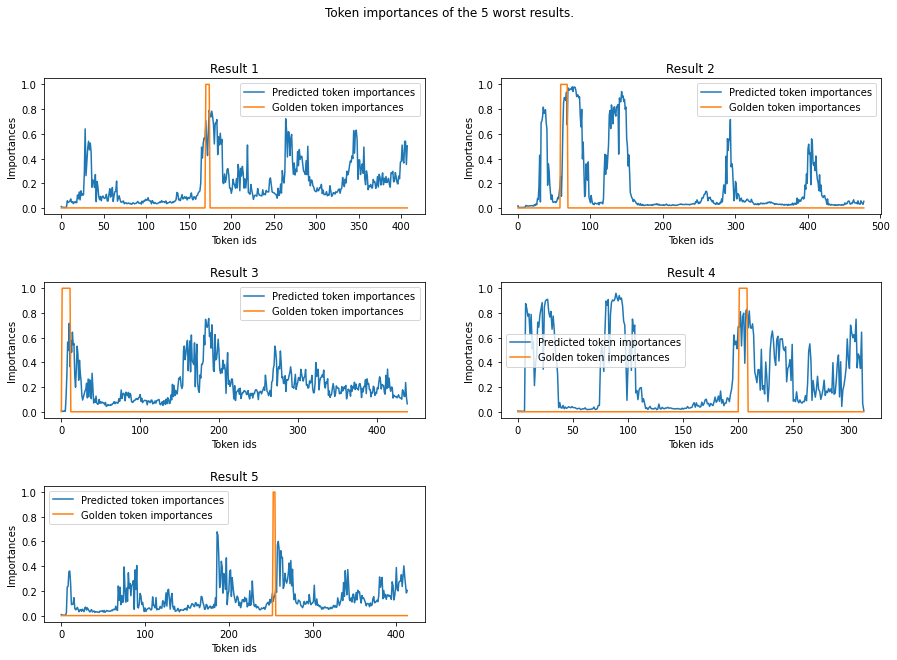

In [68]:
plot_token_importances('race', sources_statistics_dict, best_M2, use_history=use_history_M2)

For the `Race` source the errors are the following:
1. The question required to output a name of a person as an answer and the model did so, although returning a wrong one.
2. The name of an event was requested by the question, although the model provided a completely out of place answer.
3. A choice between two values was asked, however the model produced a completely irrelevant answer. It is worth reminding that according to the paper, these kinds of answers that select one of multiple choices provided in the question are around the $1.8\%$ of the *free-form answers*.
4. A first person name was expected, while the model answered with a common noun.
5. The question asked to output a profession of a person and the model managed to understand that, while answering with a wrong one.

#### 7.2.5 Wikipedia

In [69]:
show_worst_errors('wikipedia', sources_statistics_dict, show_history=use_history_M2)

* Passage span: After the Fall of Rome, the Catholic Church became the sole preserver
* Question: "After Rome fell, who was the only preserver of literate scholarship in Western Europe?"
* Gold Answer: "the Catholic Church"
* Predicted Answer: "yes"
* F1 SQuAD: 0.0

* Passage span:  Empire was replaced by the parliamentary Weimar Republic.
* Question: "After that event, What was the Empire replaced by?"
* Gold Answer: "Weimar Republic."
* Predicted Answer: "germany"
* F1 SQuAD: 0.0

* Passage span: be in a Council of Europe member country
* Question: "And another?"
* Gold Answer: "be in a Council of Europe member country"
* Predicted Answer: "yes"
* F1 SQuAD: 0.0

* Passage span: Holstein
* Question: "And another?"
* Gold Answer: "Holstein"
* Predicted Answer: "jutland"
* F1 SQuAD: 0.0

* Passage span: born Joseph Aloisius Ratzinger
* Question: "And his last name?"
* Gold Answer: "Ratzinger"
* Predicted Answer: "pope paul iii"
* F1 SQuAD: 0.0



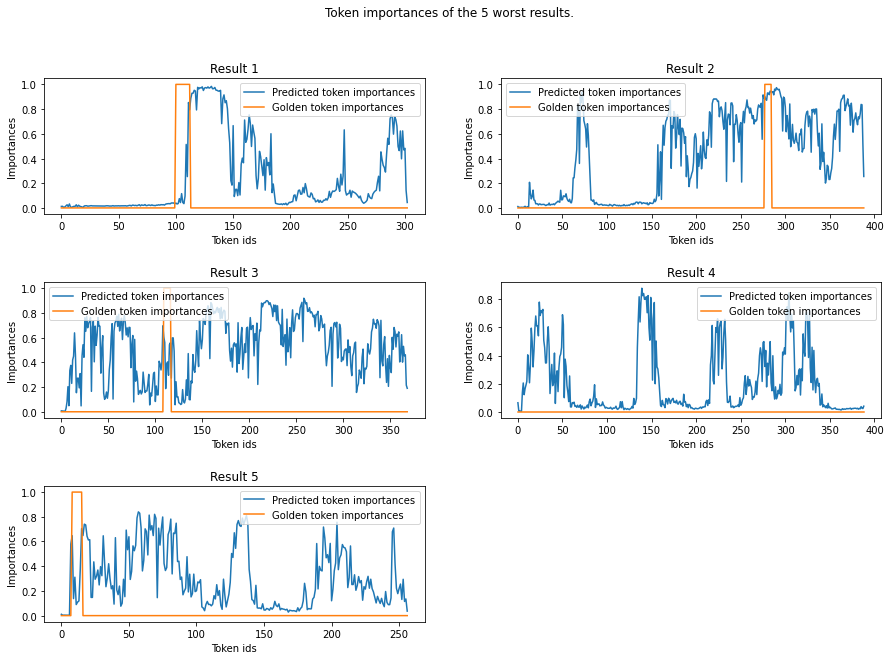

In [70]:
plot_token_importances('wikipedia', sources_statistics_dict, best_M2, use_history=use_history_M2)

Finally, for the `Wikipedia` source the errors are the following:
1. Again, "yes" is outputed by the model, but the answer is not feasible even out of context.
2. The model outputed a wrong noun than the one expected by the question.
3. "yes" is once again provided as an answer. The result may be considered consistent with the question if taken out of context.
4. A similar error to the one of the second result is obtained. It is interesting to observe that in the *Token Importances Extractor* result no rationale is obtained as the true one. The reason of that behaviour can be found in the fact that the actual rationale was composed of a single word that was probably an OOV word for the used tokenizer.
5. A pontiff last name was asked, although the model answered with a different pope's papal name.

#### 7.2.6 Recap

The model `prajjwal1/bert-tiny` is particularly bad with respect to `distilroberta-base`. This is expected, since the former model is extremely lightweight and less complex than the latter.

As previously explained, the *Token Importances Extractor* seems to be pretty inconsistent and unreliable for what concerns the worst errors.

Most of the given answers are completely unrelated to the questions even out of context and the model often wrongly predicts "yes" as an answer. It is interesting to notice that for the given cases "yes" is the only present choice between "yes/no" answers. This can be possibly explained by the fact that the experiment of the paper illustrated that positive answers are more common than negative ones among *free-form answers* ($48.5\%$ vs $30.3\%$).

Moreover, this model does not use the history of the conversation to generate the answer to a question. As expected, most of the errors are obtained from questions that are pondered in an already enstablished conversation.